In [1]:
import numpy as np
import matplotlib.pyplot as plt
import RSSPython as rs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.path import Path
from matplotlib.patches import PathPatch

In [2]:
from scipy import interpolate
from scipy.optimize import dual_annealing
from scipy.optimize import basinhopping

In [3]:
# create class to construct model
class LayeredModel:
    def __init__(self):
        self.nl = 0
        self.nx = 0
        self.nz = 0
        self.dx = 20
        self.dz = 20
        self.layers = np.zeros([self.nz,self.nx])
        self.model  = np.zeros([self.nz,self.nx])
        
    def Layers(self,horizons):
        """horisons [top1,bottom1,modelbottom]"""
        self.nl = horizons.shape[0] - 1
        self.nx = horizons.shape[1]
        self.nz = int(horizons[-1][0] / self.dz + 1)
        self.layers = np.zeros([self.nz,self.nx])
        
        for lr in range(self.nl+1):
            if lr==1:
                for x in range(self.nx):
                    thickn = horizons[lr][x] - horizons[lr-1][x]
                    
                    h_ = int(thickn//self.dz + thickn%self.dz) 
                    thickn+=thickn%self.dz
                             
                    h = np.linspace(self.dz,thickn,h_)
                    self.layers[1:h_+1,x] = h
                             
            elif lr==2:
                for x in range(self.nx):
                    thickn = horizons[lr][x] - horizons[lr-1][x]
                    
                    h_ = int(thickn//self.dz + thickn%self.dz) 
                    thickn+=thickn%self.dz
                    h = np.linspace(self.dz,thickn,h_)
                    h_ = self.layers.shape[0]-h_
                    
                
                    self.layers[h_:,x] = h
    def BuildModel(self,a,b):
        for_idx = np.diff(self.layers,axis=0)
        grad = np.zeros_like(self.layers)
        vel  = np.zeros_like(self.layers)
        self.model = np.zeros_like(self.layers)
        for i in range(self.layers.shape[1]):
            idx = np.argmin(for_idx[:,i])
            
            grad[1:idx+1,i] = b[0]
            grad[idx+2:,i] = b[1]
            
            vel[:idx+1,i] = a[0]
            vel[idx+1:,i] = a[1]
        grad = self.layers*grad
        self.model = vel+grad
    def ModifyModel(self,a,b):
        a = 1
        

In [39]:
# Create synthetic model
def get_model(m='true'):
    if m == 'true':
        v1,v2 = 992.0, 5443.0 
        d1, d2 = 45,20
        bedrock_depths = [18.3,19.18,13.0, 14.64,5.75,11.67,9.01,7.68]
    elif m == 'initial':
        v1,v2 = 800.0, 4400.0 
        d1, d2 = 25.9,2.9
        bedrock_depths = [18.3,19.18,13.0, 14.64,5.75,11.67,9.01,7.68]
        noise = np.random.randint(low=-2,high=2,size=len(bedrock_depths))
        bedrock_depths = np.array(bedrock_depths)+noise
        bedrock_depths = list(bedrock_depths)
        
    return v1,v2,d1,d2,bedrock_depths

v11,v22,d11,d22,bedrock_depths = get_model()

a = [v11,v22] # velocity
b = [d11,d22] # gradient
z_opt = bedrock_depths[:] # depth

nz = 41  # model 
nx = 201 # model

x = np.linspace(0,nx-1,len(z_opt)) # horizontal coor for z_opt
xi = np.linspace(0,nx-1,nx)  # x coor to interpolate
fi = interpolate.interp1d(x,z_opt,kind='linear') # interpol
zi = fi(xi) # bedrock depth for each xi
iz = np.round(zi).astype(int)

# horisons [top1,bottom1,modelbottom]
horizons = np.zeros([3,nx])
horizons[1,:] = iz
horizons[2,:] = nz - 1

# true model
L2mod = LayeredModel()
L2mod.dx,L2mod.dz=1,1
L2mod.Layers(horizons)
L2mod.BuildModel(a,b)
mod = L2mod.model

model_true = np.copy(mod)
v1t = model_true[:,75]
d1t = np.linspace(0,40,41)
x1t = d1t*0 +75

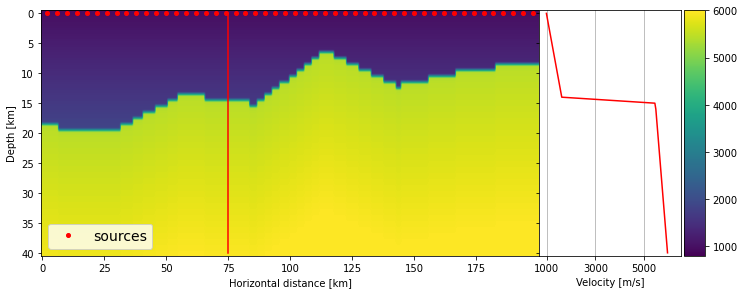

In [56]:
fig, axs = plt.subplots(ncols = 2, nrows = 1,sharey=True,
                        gridspec_kw = {'width_ratios': [3, 1]},
                       figsize=(10,4))
plt.tight_layout()
# model
ax = axs[0]
im = ax.imshow(mod,aspect='auto',vmin=800,vmax=6000)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="15%", pad=0.05)
# receivers and sources
sx = np.arange(2,202,4)
sz = sx*0
plt.colorbar(im, cax=cax)
ax.plot(sx,sz,'r.',markersize=8,label='sources')
ax.plot(x1t,d1t,'r')
ax.legend(loc='lower left',fontsize=14)
im.axes.set_xlabel('Horizontal distance [km]');im.axes.set_ylabel('Depth [km]')
ax.set_xticks(np.arange(0,200,25))

# velocity model plotting aside
axs[1].plot(v1t,d1t,'r')
axs[1].grid(axis='x')
axs[1].set_xticks([1000,3000,5000])
axs[1].set_xlim([700,6500])
axs[1].set_xlabel('Velocity [m/s]')


plt.subplots_adjust(wspace=0)

fig.savefig('Plots/TrueModel' + '.jpg',dpi=600,bbox_inches='tight',format='jpeg')

plt.show()


In [42]:
# inital model
v11,v22,d11,d22,bedrock_depths = get_model(m='initial')

a = [v11,v22] # velocity
b = [d11,d22] # gradient
z_opt = bedrock_depths[:] # depth

nz = 41  # model 
nx = 201 # model

x = np.linspace(0,nx-1,len(z_opt)) # horizontal coor for z_opt
xi = np.linspace(0,nx-1,nx)  # x coor to interpolate
fi = interpolate.interp1d(x,z_opt,kind='linear') # interpol
zi = fi(xi) # bedrock depth for each xi
iz = np.round(zi).astype(int)

# horisons [top1,bottom1,modelbottom]
horizons = np.zeros([3,nx])
horizons[1,:] = iz
horizons[2,:] = nz - 1
L2mod_i = LayeredModel()
L2mod_i.dx,L2mod_i.dz=1,1
L2mod_i.Layers(horizons)
L2mod_i.BuildModel(a,b)
init = L2mod_i.model
v1 = init[:,75]
d1 = np.linspace(0,40,41)
x1 = d1*0 +75


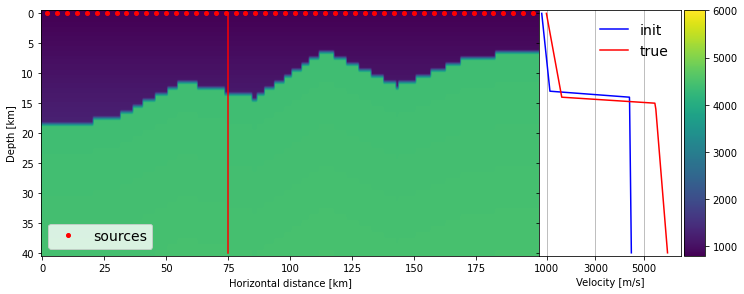

In [59]:
fig, axs = plt.subplots(ncols = 2, nrows = 1,sharey=True,
                        gridspec_kw = {'width_ratios': [3, 1]},
                       figsize=(10,4))
plt.tight_layout()
# model
ax = axs[0]
im = ax.imshow(init,aspect='auto',vmin=800,vmax=6000)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="15%", pad=0.05)
# receivers and sources
sx = np.arange(2,202,4)
sz = sx*0
plt.colorbar(im, cax=cax)
ax.plot(sx,sz,'r.',markersize=8,label='sources')
ax.plot(x1,d1,'r')
ax.legend(loc='lower left',fontsize=14)
im.axes.set_xlabel('Horizontal distance [km]');im.axes.set_ylabel('Depth [km]')
ax.set_xticks(np.arange(0,200,25))

# velocity model plotting aside
axs[1].plot(v1,d1,'b',label='init')
axs[1].plot(v1t,d1t,'r',label='true')
axs[1].legend(loc='upper right',fontsize=14,frameon=False)
axs[1].grid(axis='x')
axs[1].set_xticks([1000,3000,5000])
axs[1].set_xlim([700,6500])
axs[1].set_xlabel('Velocity [m/s]')


plt.subplots_adjust(wspace=0)

fig.savefig('Plots/InitModel' + '.jpg',dpi=600,bbox_inches='tight',format='jpeg')

plt.show()

In [97]:
# create geomertry
rss_geom = rs.RSSdata()
rss_geom.read('Data/Picks_orig.rss')

sx = np.arange(2,202,4) # sources
rx = np.arange(0,208,8) # receivers

s = sx.size
r = rx.size

sx = np.tile(sx,(r,1)).flatten(order='F') # sources for each receivers
rx = np.tile(rx,(s,1)).flatten(order='C') # receiver patter for each sources
sz = sx*0
rz = rx*0

rss_geom.geomN[1] = 1300
rss_geom.geomD[0] = 0.0005
data = rss_geom.data[:,:1300]

rss_geom.data   = data
rss_geom.srcX   = sx
rss_geom.srcZ   = sz
rss_geom.GroupX = rx
rss_geom.GroupZ = rz

rss_geom.write('Data/Picks.rss')



In [89]:
# write model
rss_m = rs.RSSdata()
rss_m.read('Data/vp_6Hz.rss')
data = rss_m.data[:201,:,:41]
rss_m.geomN[:3] = [[201],[1],[41]]
rss_m.geomD[:3] = [[1],[1],[1]]
rss_d = np.reshape(model_true.transpose(),(201,1,41))
rss_m.data = rss_d
rss_m.write('Data/truevp.rss')
rss_d = np.reshape(init.transpose(),(201,1,41))
rss_m.data = rss_d
rss_m.write('Data/initvp.rss')
